In [1]:
import matplotlib.pyplot as plt
import pyGMs as gm
import numpy as np
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
import pyro.poutine as poutine

import random
import pandas as pd

seed = 123
pyro.set_rng_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [22]:
golden_sample = torch.load('mcmc_samples_20000.pt')
dataset = torch.load("dataset.pt")
teams = torch.load("teams.pt")
teams_number = list(range(len(teams)))

dataset = random.sample(dataset, int(len(dataset) * 1))

In [23]:
def construct_ranking(samples: dict, teams) -> dict:
    return {
        team: rank for rank, team in enumerate(
            sorted(teams,
                   key=lambda i: samples[f"X{i}"].mean(), reverse=True)
        )
    }


def model(matches, n_teams):
    X = [pyro.sample(f"X{i}", dist.Normal(0, 1)) for i in range(n_teams)]

    for i, m in enumerate(matches):
        pyro.sample(f"w{i}",
                    dist.Bernoulli(logits=X[m[0]]-X[m[1]]),
                    obs=torch.tensor(1.))

In [15]:
mcmc_runs = []

for n in [1, 5, 10, 50, 100, 200]:
    nuts_kernel = pyro.infer.NUTS(model, jit_compile=False)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=n,
                           warmup_steps=20, num_chains=1)
    mcmc.run(dataset, len(teams))

    mcmc_runs.append((n, mcmc.get_samples()))

Warmup:  67%|██████▋   | 14/21 [00:14,  1.46s/it, step size=9.85e-02, acc. prob=0.710]

KeyboardInterrupt: 

In [30]:
nuts_kernel = pyro.infer.NUTS(model, jit_compile=False)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=200,
                       warmup_steps=20, num_chains=1)
mcmc.run(dataset, len(teams))

Warmup:   4%|▎         | 8/220 [00:13,  2.71s/it, step size=6.56e-02, acc. prob=0.628]

In [ ]:
mcmc_runs = []

for n in [1, 10, 50, 100, 150, 200]:
    mcmc_runs.append((n, mcmc.get_samples(n)))

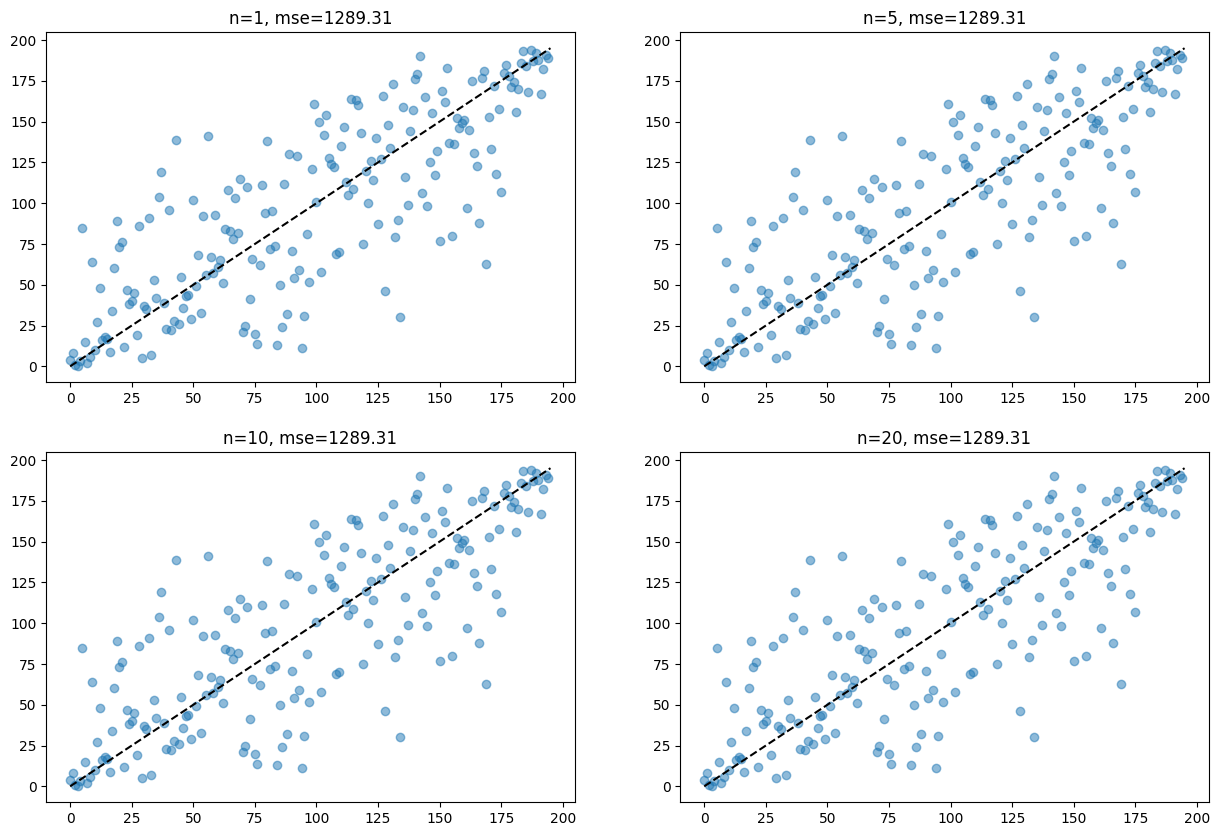

In [29]:
golden_ranking = construct_ranking(golden_sample, teams_number)

X = [golden_ranking[i] for i in teams_number]

# plot results in a subplot grid
# also show mse for each run

cols = 3

fig, axs = plt.subplots(cols, cols, figsize=(15, 10))


for i, (n, samples) in enumerate(mcmc_runs):

    ranking = construct_ranking(samples, teams_number)
    Y = [ranking[i] for i in teams_number]

    mse = np.mean((np.array(X) - np.array(Y))**2)

    ax = axs[i//cols, i % cols]
    ax.plot(X, Y, 'o', alpha=0.5)
    ax.plot([0, len(teams)], [0, len(teams)], 'k--')
    ax.set_title(f"n={n}, mse={mse:.2f}")